In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [59]:
import sqlite3

import pandas as pd

prefix = "binaryoptimization/maxcut"

db = sqlite3.connect("out/results/results.db")
if prefix:
    query = f"SELECT * FROM `results` WHERE `hid` LIKE '{prefix}%'"
else:
    query = "SELECT * FROM `results`"
results = pd.read_sql(query, db)
db.close()

results["time"] = results["reordering_time"] + results["synthesis_time"]
results.drop(["jid", "reordering_time", "synthesis_time"], axis=1, inplace=True)

results

,hid,method,n_terms,n_timesteps,order,trotterization,depth,time
0,binaryoptimization/maxcut/ciqube/ratio912-hams...,saturation,4,1,4,suzuki_trotter,20,1.877
1,binaryoptimization/maxcut/biqmac/rudy-hams/8-p...,misra_gries,499,1,2,suzuki_trotter,66,335.331
2,binaryoptimization/maxcut/biqmac/ising-hams/1-...,none,57,1,4,suzuki_trotter,205,8.629
3,binaryoptimization/maxcut/biqmac/rudy-hams/2-p...,misra_gries,860,1,4,suzuki_trotter,380,408.921
4,binaryoptimization/maxcut/biqmac/ising-hams/10...,none,65,1,4,suzuki_trotter,240,8.516
...,...,...,...,...,...,...,...,...
2126180,binaryoptimization/maxcut/biqmac/rudy-hams/2-p...,saturation,119,1,4,suzuki_trotter,160,26.303
2126181,binaryoptimization/maxcut/biqmac/rudy-hams/6-w...,misra_gries,809,1,4,suzuki_trotter,420,1209.122
2126182,binaryoptimization/maxcut/biqmac/rudy-hams/4-p...,saturation,32,1,4,suzuki_trotter,85,9.691
2126183,binaryoptimization/maxcut/biqmac/rudy-hams/10-...,misra_gries,510,1,4,suzuki_trotter,340,395.181


In [60]:
df = results.groupby(["hid", "trotterization", "n_timesteps", "order", "method"]).mean()
df = df.reset_index(level=-1)

baseline = df[df["method"] == "none"].drop(["method", "n_terms"], axis=1)
df["depth_pc"] = df["depth"] * 100 / (baseline["depth"] + 1e-3)
df["time_pc"] = df["time"] * 100 / (baseline["time"] + 1e-3)

df = df.reset_index()

df["problem_group"] = df["hid"].map(lambda hid: "/".join(hid.split("/")[:3]))

df = df.astype({"n_terms": int, "depth": int, "n_timesteps": int, "order": int})
df

,hid,trotterization,n_timesteps,order,method,n_terms,depth,time,depth_pc,time_pc,problem_group
0,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,1,2,misra_gries,45,18,8.6228,54.543802,394.563924,binaryoptimization/maxcut/biqmac
1,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,1,2,none,45,33,2.1844,99.996970,99.954242,binaryoptimization/maxcut/biqmac
2,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,1,2,saturation,45,18,8.3912,56.967971,383.966322,binaryoptimization/maxcut/biqmac
3,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,1,4,misra_gries,45,90,13.6602,54.545124,253.709000,binaryoptimization/maxcut/biqmac
4,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,1,4,none,45,165,5.3832,99.999394,99.981427,binaryoptimization/maxcut/biqmac
...,...,...,...,...,...,...,...,...,...,...,...
425243,binaryoptimization/maxcut/random/ham-graph-sta...,suzuki_trotter,1,2,none,899,1797,117.7206,99.999944,99.999151,binaryoptimization/maxcut/random
425244,binaryoptimization/maxcut/random/ham-graph-sta...,suzuki_trotter,1,2,saturation,899,1797,541.7308,99.999944,460.179610,binaryoptimization/maxcut/random
425245,binaryoptimization/maxcut/random/ham-graph-sta...,suzuki_trotter,1,4,misra_gries,899,8985,589.3960,99.999989,344.905557,binaryoptimization/maxcut/random
425246,binaryoptimization/maxcut/random/ham-graph-sta...,suzuki_trotter,1,4,none,899,8985,170.8852,99.999989,99.999415,binaryoptimization/maxcut/random


In [61]:
df["problem_group"].unique()

array(['binaryoptimization/maxcut/biqmac',
       'binaryoptimization/maxcut/ciqube',
       'binaryoptimization/maxcut/random'], dtype=object)

In [62]:
# Filter rows of interest

df.dropna(inplace=True)
df = df[
    (df["trotterization"] == "suzuki_trotter")
    & (df["n_timesteps"] == 1)
    & (df["order"] == 4)
    & (df["problem_group"].str.startswith("binaryoptimization/maxcut"))
    & (~df["method"].str.endswith("_c"))
]

df.shape

(212621, 11)

In [64]:
# Filter and remove outliers

from scipy.stats import zscore
import numpy as np

MAX_ZSCORE = 3

x = df[["time", "n_terms", "depth", "time_pc"]].to_numpy()
p = (np.abs(zscore(x)) < MAX_ZSCORE).all(axis=1)
print("Dropping", len(df) - p.sum(), "rows")
df = df[p]
df

Dropping 14714 rows


,hid,trotterization,n_timesteps,order,method,n_terms,depth,time,depth_pc,time_pc,problem_group
3,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,1,4,misra_gries,45,90,13.6602,54.545124,253.709000,binaryoptimization/maxcut/biqmac
4,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,1,4,none,45,165,5.3832,99.999394,99.981427,binaryoptimization/maxcut/biqmac
5,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,1,4,saturation,45,93,12.0524,56.363295,223.847554,binaryoptimization/maxcut/biqmac
9,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,1,4,misra_gries,4852,1000,533.9510,51.150869,126.841147,binaryoptimization/maxcut/biqmac
11,binaryoptimization/maxcut/biqmac/ising-hams/1-...,suzuki_trotter,1,4,saturation,4852,1047,968.8682,53.554960,230.156613,binaryoptimization/maxcut/biqmac
...,...,...,...,...,...,...,...,...,...,...,...
425233,binaryoptimization/maxcut/random/ham-graph-sta...,suzuki_trotter,1,4,misra_gries,8,75,3.3028,99.998667,244.506959,binaryoptimization/maxcut/random
425234,binaryoptimization/maxcut/random/ham-graph-sta...,suzuki_trotter,1,4,none,8,75,1.3498,99.998667,99.925970,binaryoptimization/maxcut/random
425235,binaryoptimization/maxcut/random/ham-graph-sta...,suzuki_trotter,1,4,saturation,8,75,2.5946,99.998667,192.078768,binaryoptimization/maxcut/random
425240,binaryoptimization/maxcut/random/ham-graph-sta...,suzuki_trotter,1,4,none,89,885,11.0216,99.999887,99.990928,binaryoptimization/maxcut/random


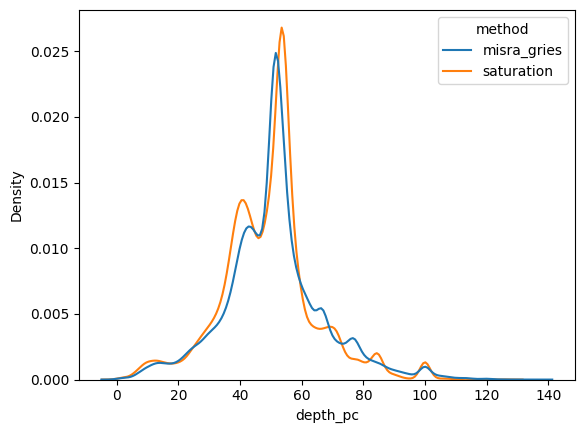

In [66]:
import seaborn as sns

_df = df[df["method"] != "none"]
ax = sns.kdeplot(data=_df, x="depth_pc", hue="method")

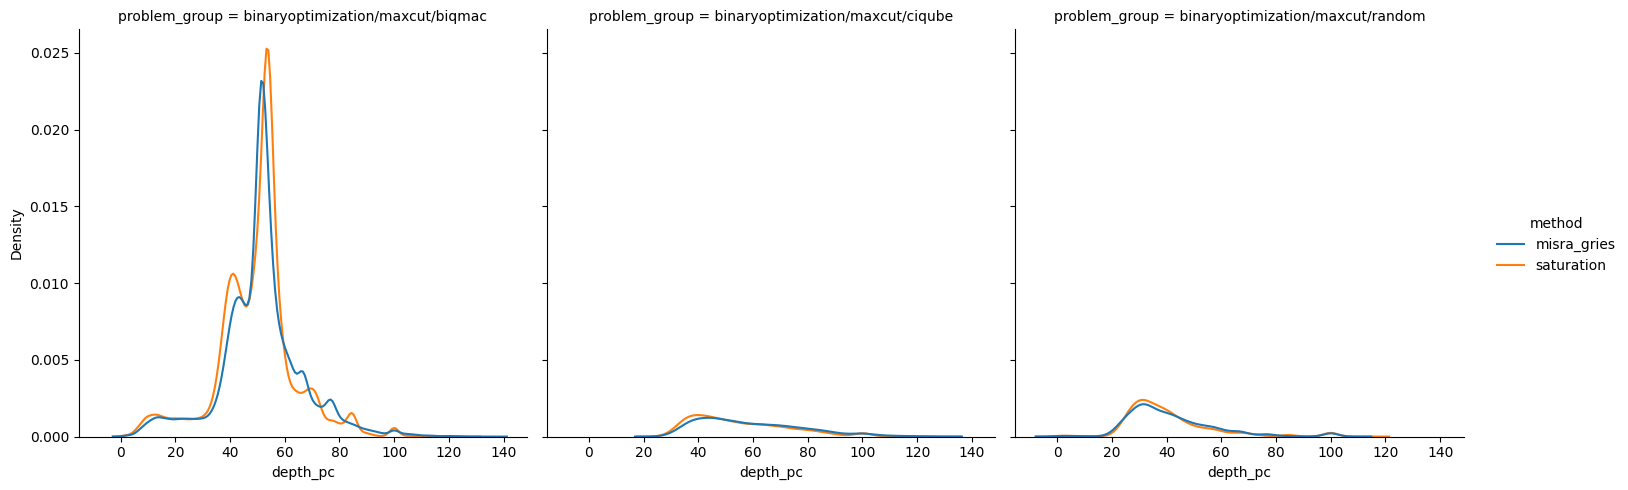

In [67]:
import seaborn as sns

_df = df[df["method"] != "none"]
ax = sns.displot(
    data=_df,
    x="depth_pc",
    col="problem_group",
    hue="method",
    kind="kde",
)

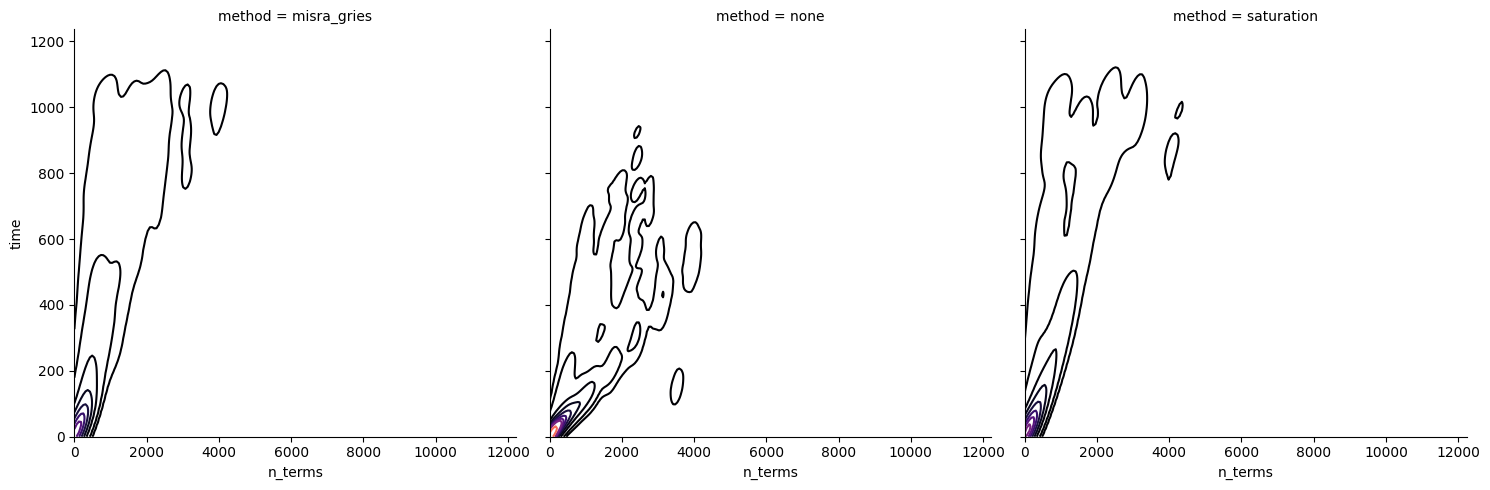

In [68]:
import seaborn as sns

ax = sns.displot(
    data=df,
    x="n_terms",
    y="time",
    col="method",
    kind="kde",
    clip=((0, None), (0, None)),
    cmap="magma",
)

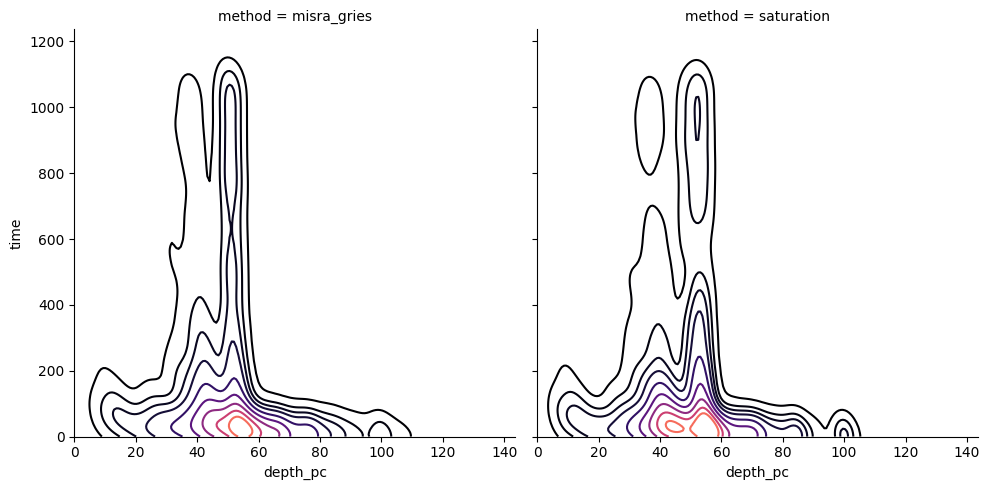

In [72]:
import seaborn as sns

_df = df[df["method"] != "none"]
ax = sns.displot(
    data=_df,
    x="depth_pc",
    y="time",
    col="method",
    kind="kde",
    cmap="magma",
    clip=((0, None), (0, None)),
)

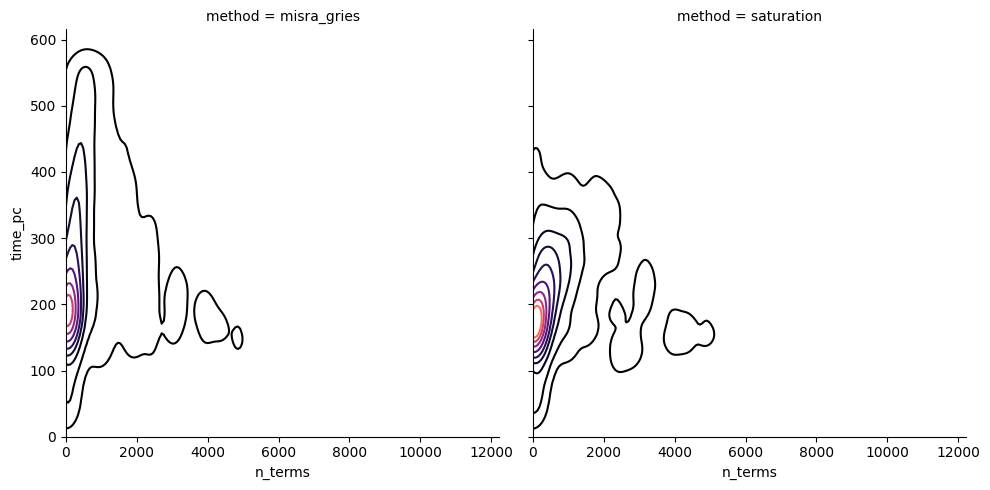

In [74]:
import seaborn as sns

_df = df[df["method"] != "none"]
ax = sns.displot(
    data=_df,
    x="n_terms",
    y="time_pc",
    col="method",
    kind="kde",
    cmap="magma",
    clip=((0, None), (0, None)),
)

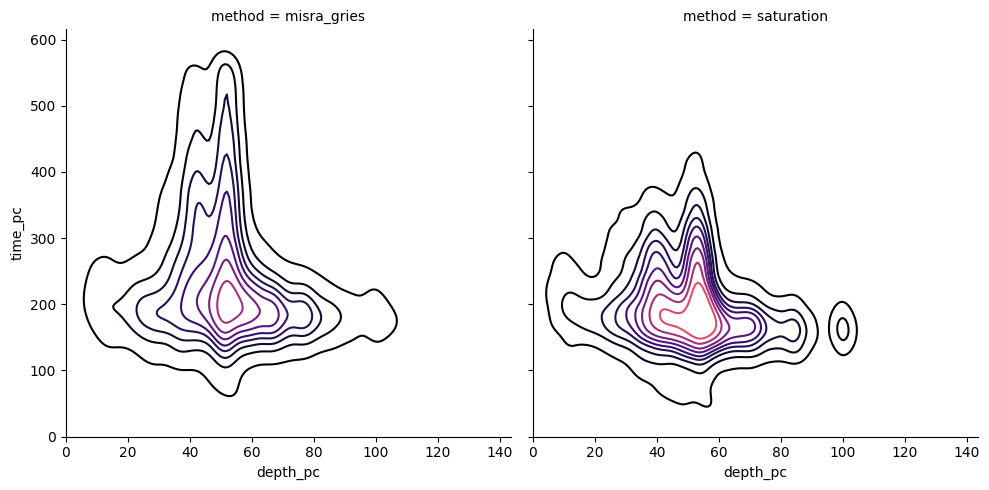

In [75]:
import seaborn as sns

_df = df[df["method"] != "none"]
ax = sns.displot(
    data=_df,
    x="depth_pc",
    y="time_pc",
    col="method",
    kind="kde",
    cmap="magma",
    clip=((0, None), (0, None)),
)